<a href="https://colab.research.google.com/github/kkhhmm3103/SSU_Datathon2025/blob/main/LDA%E1%84%90%E1%85%A9%E1%84%91%E1%85%B5%E1%86%A8%E1%84%86%E1%85%A9%E1%84%83%E1%85%A6%E1%86%AF%E1%84%85%E1%85%B5%E1%86%BC_%E1%84%83%E1%85%A9%E1%86%BC%E1%84%8C%E1%85%A5%E1%86%A8%E1%84%86%E1%85%A9%E1%84%83%E1%85%A6%E1%86%AF%E1%84%85%E1%85%B5%E1%86%BC_%E1%84%8C%E1%85%A6%E1%84%8E%E1%85%AE%E1%86%AF%E1%84%8B%E1%85%AD%E1%86%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import os
import numpy as np
import re
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel
import warnings
import logging
import matplotlib
from matplotlib import font_manager, rc
import platform

# AI 추세 파악

In [ ]:
# 깨짐방지
if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# 로그/경고 정리
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)
warnings.filterwarnings("ignore", message="Glyph .* missing from font.*")

In [ ]:
DATA_PATH = "keyword_bert_df.csv"

papers = pd.read_csv(DATA_PATH, encoding="utf-8-sig")

print(papers.shape)
papers.head()

(47110, 12)


,NODE_ID,NODE_TTLE,NODE_TTLE_EN,PBSH,NODE_CLSS_01,NODE_CLSS_02,KYWD,ABST_KR,ABST_EN,KW_LIST_RAW,KW_LIST_NORM,KYWD_NORM
0,NODE09329326,Application and development of pyrolysis technology in petroleum oily sludge treatment,Application and development of pyrolysis technology in petroleum oily sludge treatment,202102,공학,건축공학,"Pyrolysis technology,Product distribution,Oily sludge,Activated carbon",NaN,"With the enhancement of public awareness of environmental protection, the harm of oily sludge has gradually been paid attention to. As a kind of dangerous solid waste, the arbitrary disposal of oily sludge will cause quite serious harm to both the environment and human beings. Research on the treatment methods of oily sludge has become a hot spot recently. At present, treatment methods of oily sludge are various, mainly including pyrolysis, direct combustion, freeze-thaw treatment, biological treatment, solvent extraction, thermochemical cleaning, ultrasound-assisted treatment or joint technology, etc. Based on the consideration of economic benefits, social benefits and treatment difficulties, pyrolysis has been considered to be the most appropriate method for oily sludge treatment. Syngas, liquid oil and char can be obtained from pyrolysis of oily sludge, which can meet different needs. In this paper, the pyrolysis technology of oily sludge is reported in detail, including pyrolysis methods, operational parameters and pyrolysis products of oily sludge. On the basis, the advantages and limitations of oily sludge pyrolysis technology are discussed, together with the report of feasibility of pyrolysis technology of oily sludge. Moreover, the development trend of pyrolysis technology of oily sludge is prospected for the future work.","['Pyrolysis technology', 'Product distribution', 'Oily sludge', 'Activated carbon']","['activated carbon', 'oily sludge', 'product distribution', 'pyrolysis technology']","activated carbon, oily sludge, product distribution, pyrolysis technology"
1,NODE09329327,Removal of antibiotics from wastewater and its problematic effects on microbial communities by bioelectrochemical Technology: Current knowledge and future perspectives,Removal of antibiotics from wastewater and its problematic effects on microbial communities by bioelectrochemical Technology: Current knowledge and future perspectives,202102,공학,건축공학,"Antibiotic resistance bacteria (ARB),Antibiotic resistance genes (ARGs),Bioelectrochemical System,Biodegradation,Microbial communities,Wastewater Treatment",NaN,"In this review, antibiotics are considered an emerging pollutant that has drawn worldwide attention in recent years. Therefore, the effective removal of antibiotic contaminants has become a hot issue in the field of environmental research. Most antibiotics applied to humans eventually enter municipal Wastewater Treatment Plants (WWTPs), because there are no appropriate commercially available pretreatment techniques. However, increasing anthropogenic activities, the high demand for animal-protein in developing countries as a nutritional alternative, and the extensive usage of antibiotics are mainly responsible for the persistence of antibiotic pollutants. One of the serious concerns regarding the presence of antibiotics in water and their potential role in exacerbating the emergence of antibiotics-resistance bacteria (ARB) and antibiotics-resistance genes (ARGs). In recent years, bioelectrochemical technologies are found promising for suppressing antibiotic contaminants through microbial metabolism and electrochemical redox reactions. Therefore, this review provides up-to-date insight research on bioelectrochemical systems (BESs), which improves the removal of the antibiotic in an efficient way. The focus of this review has been on the environmental sources of antibiotics, their health effects and possible degradation pathways, bacterial-antibiotics resistance mechanisms, and treatment of antibiotic-contained water using BES technology.","['Antib

In [ ]:
def kw_str_to_list(s):
    if pd.isna(s):
        return []
    s = str(s).strip()
    if not s:
        return []
    # 쉼표 기준 분리
    ks = re.split(r"\s*,\s*", s)
    # 공백 정리 + 빈 값 제거 + 소문자 통일
    out = []
    for k in ks:
        k = str(k).strip().lower()
        k = re.sub(r"\s+", " ", k)
        if k:
            out.append(k)
    # 문서 내 중복 제거 (순서 유지)
    return list(dict.fromkeys(out))

papers["kw_list"] = papers["KYWD_NORM"].apply(kw_str_to_list)
papers["kw_n"] = papers["kw_list"].apply(len)

print("kw_n describe:")
print(papers["kw_n"].describe())
print("\nkw_n value counts:")
print(papers["kw_n"].value_counts().head(10))

print("\nSample check:")
print(papers[["KYWD_NORM", "kw_list"]].head(3).to_string(index=False))

kw_n describe:
count    47110.000000
mean         6.065740
std          2.250783
min          1.000000
25%          5.000000
50%          5.000000
75%          8.000000
max         27.000000
Name: kw_n, dtype: float64

kw_n value counts:
5     16777
4      7812
6      6094
10     4620
8      3570
3      2296
9      2280
7      2191
12      639
11      359
Name: kw_n, dtype: int64

Sample check:
                                                                                                                                          KYWD_NORM                                                                                                                                               kw_list
                                                                          activated carbon, oily sludge, product distribution, pyrolysis technology                                                                           [activated carbon, oily sludge, product distribution, pyrolysis technology]
antibi

In [ ]:
# 네트워크 분석은 키워드 2개 이상 필요
papers_net = papers[papers["kw_n"] >= 2].copy()
print("papers_net shape:", papers_net.shape)

# 전체 키워드 빈도 계산
all_kws = [k for ks in papers_net["kw_list"] for k in ks]
freq = Counter(all_kws)

print("unique keywords:", len(freq))
print("top 20 keywords:", freq.most_common(20))

# 희귀 키워드 제거
MIN_FREQ = 10

papers_net["kw_list_f"] = papers_net["kw_list"].apply(
    lambda ks: [k for k in ks if freq[k] >= MIN_FREQ]
)
papers_net["kw_n_f"] = papers_net["kw_list_f"].apply(len)

# 희귀 제거 후에도 키워드 2개 이상만 유지
papers_net2 = papers_net[papers_net["kw_n_f"] >= 2].copy()
print("papers_net2 shape:", papers_net2.shape)
print(papers_net2["kw_n_f"].describe())

papers_net shape: (47100, 14)
unique keywords: 155286
top 20 keywords: [('deep learning', 2035), ('machine learning', 1056), ('artificial intelligence', 908), ('convolutional neural network', 734), ('computational fluid dynamic', 632), ('object detection', 446), ('internet of things', 371), ('finite element analysis', 368), ('reinforcement learning', 359), ('optimization', 334), ('covid-19', 316), ('nursing', 300), ('long short-term memory', 294), ('unmanned aerial vehicle', 271), ('virtual reality', 271), ('big data', 269), ('metaverse', 268), ('simulation', 265), ('large language model', 235), ('generative ai', 234)]
papers_net2 shape: (20146, 16)
count    20146.000000
mean         2.782537
std          1.022028
min          2.000000
25%          2.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: kw_n_f, dtype: float64


In [ ]:
# AI 연관성 점수(ai_score) 계산을 위한 PPR 로드
AI_BUNDLE_KW_PATHS = [
    "ai_bundle_keywords.csv",
    r"/mnt/data/ai_bundle_keywords.csv",   # (업로드된 경로)
]

kw_path = next((p for p in AI_BUNDLE_KW_PATHS if os.path.exists(p)), None)
if kw_path is None:
    raise FileNotFoundError(f"ai_bundle_keywords.csv를 찾지 못함. 후보: {AI_BUNDLE_KW_PATHS}")

bundle = pd.read_csv(kw_path, encoding="utf-8-sig")

# 필수 컬럼 확인
need = {"keyword", "ai_relatedness_ppr"}
if not need.issubset(bundle.columns):
    raise ValueError(f"ai_bundle_keywords.csv에 필요한 컬럼이 없음: {need - set(bundle.columns)} / 현재: {list(bundle.columns)}")

bundle["keyword"] = bundle["keyword"].astype(str).str.strip().str.lower()

# PPR 점수 딕셔너리: keyword -> ai_relatedness_ppr
ppr_map = dict(zip(bundle["keyword"], bundle["ai_relatedness_ppr"]))

def doc_ai_score(kw_list):
    """논문 1편의 키워드 리스트 -> AI 연관성 점수(PPR 합)"""
    if not isinstance(kw_list, list):
        return 0.0
    return float(sum(ppr_map.get(k, 0.0) for k in kw_list))

# papers_net2에 AI 점수 컬럼 추가
papers_net2["ai_score"] = papers_net2["kw_list_f"].apply(doc_ai_score)

print("ai_score describe:")
print(papers_net2["ai_score"].describe())
print("ai_score 상위 샘플(5개):")

ai_score describe:
count    20146.000000
mean         0.017357
std          0.038977
min          0.000000
25%          0.000000
50%          0.000000
75%          0.007777
max          0.231729
Name: ai_score, dtype: float64
ai_score 상위 샘플(5개):


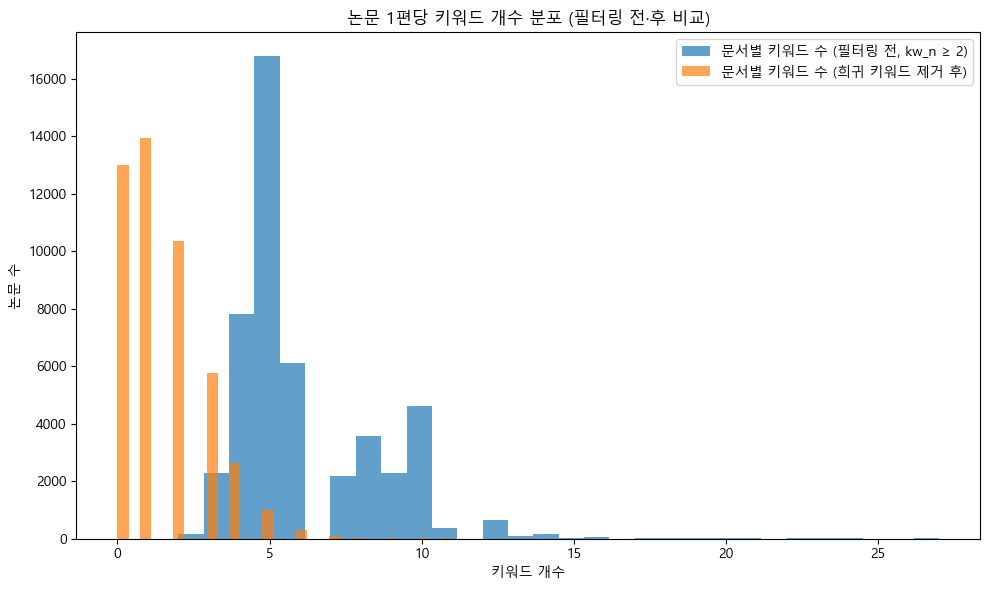

In [ ]:
# 문서당 키워드 개수 분포
# → 희귀 키워드 제거 이후에도 키워드 수가 과도하게 감소하지 않았음을 확인
plt.figure(figsize=(10, 6))

plt.hist(
    papers_net["kw_n"],
    bins=30,
    alpha=0.7,
    label="문서별 키워드 수 (필터링 전, kw_n ≥ 2)"
)

plt.hist(
    papers_net["kw_n_f"],
    bins=30,
    alpha=0.7,
    label="문서별 키워드 수 (희귀 키워드 제거 후)"
)

plt.title("논문 1편당 키워드 개수 분포 (필터링 전·후 비교)")
plt.xlabel("키워드 개수")
plt.ylabel("논문 수")

plt.legend()
plt.tight_layout()
plt.show()

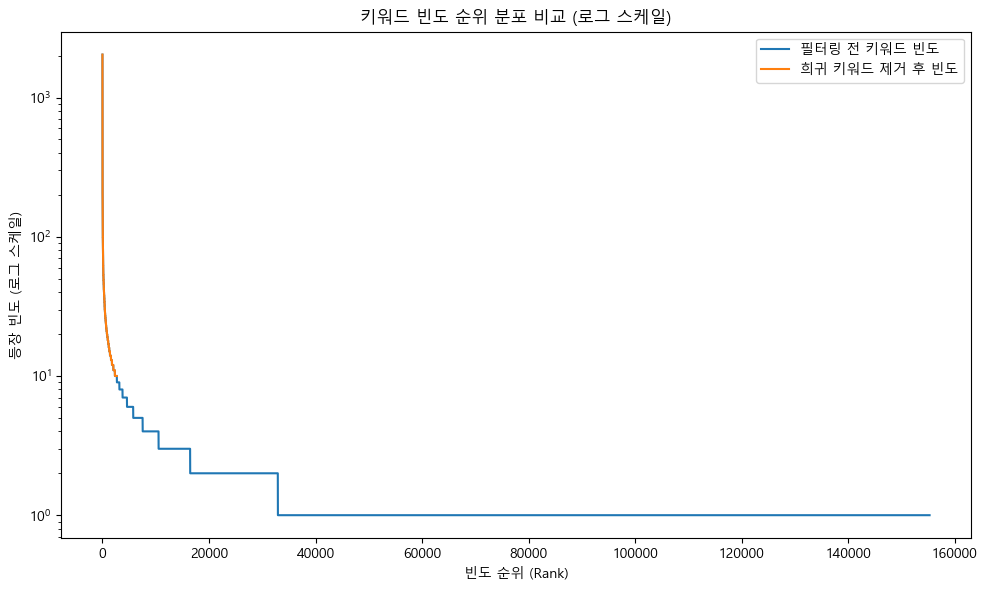

In [ ]:
# BEFORE (필터 전)
all_before = [k for ks in papers_net["kw_list"] for k in ks]
freq_before = Counter(all_before)
counts_before = np.array(sorted(freq_before.values(), reverse=True))

# AFTER (필터 후)
all_after = [k for ks in papers_net["kw_list_f"] for k in ks]
freq_after = Counter(all_after)
counts_after = np.array(sorted(freq_after.values(), reverse=True))

plt.figure(figsize=(10, 6))

plt.plot(counts_before, label="필터링 전 키워드 빈도")
plt.plot(counts_after, label="희귀 키워드 제거 후 빈도")

plt.yscale("log")

plt.title("키워드 빈도 순위 분포 비교 (로그 스케일)")
plt.xlabel("빈도 순위 (Rank)")
plt.ylabel("등장 빈도 (로그 스케일)")

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 연도/월 생성 (PBSH: YYYYMM)
papers_net2["PBSH_str"] = papers_net2["PBSH"].astype(str)

mask = papers_net2["PBSH_str"].str.fullmatch(r"\d{6}", na=False)
papers_net2 = papers_net2[mask].copy()

papers_net2["year"] = papers_net2["PBSH_str"].str[:4].astype(int)
papers_net2["month"] = papers_net2["PBSH_str"].str[4:6].astype(int)

papers_net2 = papers_net2[
    (papers_net2["month"] >= 1) & (papers_net2["month"] <= 12)
].copy()

print("year range:", papers_net2["year"].min(), "-", papers_net2["year"].max())

# 분야 컬럼 정리
papers_net2["field1"] = papers_net2["NODE_CLSS_01"].astype(str).str.strip()
papers_net2["field2"] = (
    papers_net2["NODE_CLSS_02"]
    .fillna("미상")
    .astype(str)
    .str.strip()
)
papers_net2.loc[papers_net2["field2"] == "", "field2"] = "미상"

print("\nfield2 top 10:")
print(papers_net2["field2"].value_counts().head(10))

# 전/후 구간 태깅
def period_label(y):
    if y in (2021, 2022):
        return "before"
    if y in (2024, 2025):
        return "after"
    return "other"

papers_net2["period"] = papers_net2["year"].apply(period_label)

print("\nperiod counts:")
print(papers_net2["period"].value_counts())

year range: 2021 - 2025

field2 top 10:
전기전자공학      6739
기계공학        3272
컴퓨터학        3158
건축공학        2783
공학 일반       2393
산업공학         558
기타 공학        516
재료·에너지공학     359
화학공학         212
조선해양공학       156
Name: field2, dtype: int64

period counts:
before    8008
after     7992
other     4146
Name: period, dtype: int64


In [ ]:
# AI 번들(PPR 점수) 로드
AI_BUNDLE_KW_PATHS = ["ai_bundle_keywords.csv", r"/mnt/data/ai_bundle_keywords.csv"]
kw_path = next((p for p in AI_BUNDLE_KW_PATHS if os.path.exists(p)), None)
if kw_path is None:
    raise FileNotFoundError(f"ai_bundle_keywords.csv를 찾지 못함: {AI_BUNDLE_KW_PATHS}")

bundle = pd.read_csv(kw_path, encoding="utf-8-sig")

need = {"keyword", "ai_relatedness_ppr"}
if not need.issubset(bundle.columns):
    raise ValueError(f"필수 컬럼 없음: {need - set(bundle.columns)} / 현재: {list(bundle.columns)}")

bundle["keyword"] = bundle["keyword"].astype(str).str.strip().str.lower()
bundle["ai_relatedness_ppr"] = bundle["ai_relatedness_ppr"].astype(float)

# keyword -> ppr 점수
ppr_map = dict(zip(bundle["keyword"], bundle["ai_relatedness_ppr"]))
AI_KEYWORDS = set(ppr_map.keys())

print("AI_KEYWORDS size:", len(AI_KEYWORDS))ㄴ

AI_KEYWORDS size: 200


In [ ]:
# 키워드 공출현 네트워크 생성 함수
def build_kw_network(df_subset, min_co=5, top_kws=150):
    """
    키워드 공출현(co-occurrence) 네트워크 생성
    - 논문 내 함께 등장한 키워드 쌍을 edge로 연결
    - 너무 희귀한 키워드는 제거하기 위해 상위 top_kws만 사용
    - min_co 이상 공출현한 경우만 edge로 추가
    """
    # 키워드 빈도 집계 -> 상위 키워드만 유지
    all_kws = [k for ks in df_subset["kw_list_f"] for k in ks]
    top = set([k for k, _ in Counter(all_kws).most_common(top_kws)])

    # 키워드 쌍 공출현 카운트
    pair_counts = Counter()
    for ks in df_subset["kw_list_f"]:
        ks = [k for k in set(ks) if k in top]  # 중복 제거
        ks.sort()
        for i in range(len(ks)):
            for j in range(i + 1, len(ks)):
                pair_counts[(ks[i], ks[j])] += 1

    G = nx.Graph()
    for (a, b), w in pair_counts.items():
        if w >= min_co:
            G.add_edge(a, b, weight=w)

    return G

# 전/후 데이터 분리
before_df = papers_net2[papers_net2["period"] == "before"].copy()
after_df  = papers_net2[papers_net2["period"] == "after"].copy()

print("before papers:", len(before_df))
print("after papers :", len(after_df))

# 전/후 네트워크 생성
G_before = build_kw_network(before_df, min_co=5, top_kws=150)
G_after  = build_kw_network(after_df,  min_co=5, top_kws=150)

print("G_before nodes / edges:", G_before.number_of_nodes(), G_before.number_of_edges())
print("G_after  nodes / edges:", G_after.number_of_nodes(),  G_after.number_of_edges())

before papers: 8008
after papers : 7992
G_before nodes / edges: 101 168
G_after  nodes / edges: 99 167


Top20 키워드 등장 변화 (PPR 가중 X)


,keyword,before_cnt,after_cnt,delta_cnt,ppr,delta_score
3,large language model,0,181,181,0.029782,5.390466
5,generative ai,0,166,166,0.025560,4.242914
1,artificial intelligence,259,366,107,0.035462,3.794394
15,chatgpt,2,76,74,0.010034,0.742538
6,retrieval augmented generation,0,58,58,0.017534,1.016952
10,reinforcement learning,86,128,42,0.013658,0.573651
8,anomaly detection,54,96,42,0.015412,0.647317
9,natural language processing,54,76,22,0.015282,0.336195
7,object detection,159,176,17,0.017334,0.294670
19,explainable ai,22,36,14,0.008453,0.118344


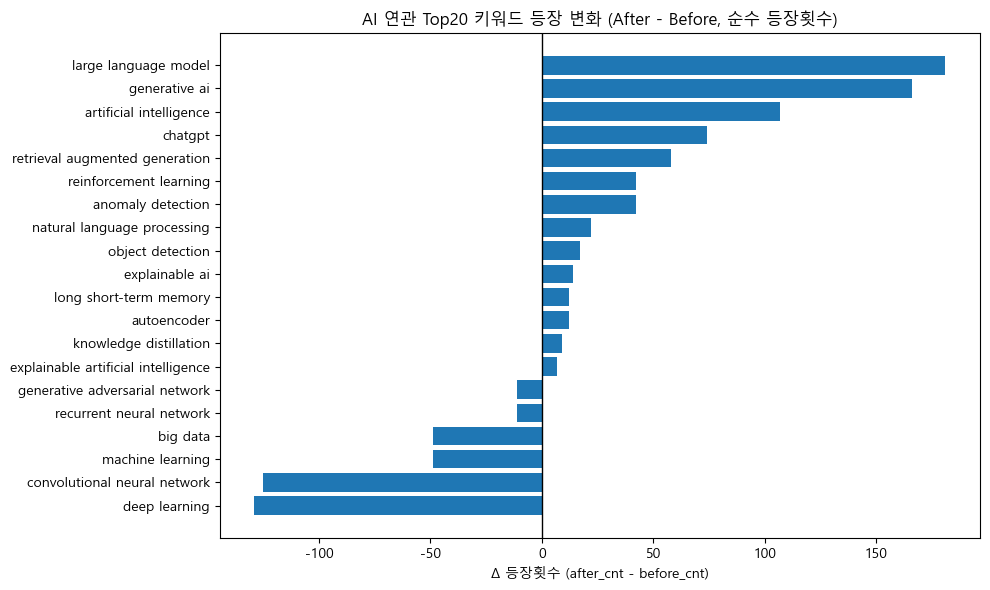

In [ ]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Top20 키워드 선정 기준
TOP_N = 20
top20_list = (
    bundle.sort_values("ai_relatedness_ppr", ascending=False)
          .head(TOP_N)["keyword"]
          .astype(str).str.strip().str.lower()
          .tolist()
)

# 기간별 등장횟수 집계 (kw_list_f 기준)
def period_keyword_counts(df_period):
    all_kws = [k for ks in df_period["kw_list_f"] for k in ks]
    return Counter(all_kws)

before_df = papers_net2[papers_net2["period"] == "before"]
after_df  = papers_net2[papers_net2["period"] == "after"]

cnt_before = period_keyword_counts(before_df)
cnt_after  = period_keyword_counts(after_df)

# PPR 가중 X: 순수 등장 기반 변화표
rows = []
for k in top20_list:
    b = cnt_before.get(k, 0)
    a = cnt_after.get(k, 0)
    rows.append({
        "keyword": k,
        "before_cnt": b,
        "after_cnt": a,
        "delta_cnt": a - b,                 #  PPR 가중 X
        "ppr": float(ppr_map.get(k, 0.0)),
        "delta_score": float(ppr_map.get(k, 0.0)) * (a - b)
    })

trend_cnt = pd.DataFrame(rows).sort_values("delta_cnt", ascending=False)

print("Top20 키워드 등장 변화 (PPR 가중 X)")
display(trend_cnt)

# 그래프: Δ count
plot_df = trend_cnt.sort_values("delta_cnt").copy()

plt.figure(figsize=(10, 6))
plt.barh(plot_df["keyword"], plot_df["delta_cnt"])
plt.axvline(0, color="black", linewidth=1)
plt.title("AI 연관 Top20 키워드 등장 변화 (After - Before, 순수 등장횟수)")
plt.xlabel("Δ 등장횟수 (after_cnt - before_cnt)")
plt.tight_layout()
plt.show()

ai_score describe:
count    20146.000000
mean         0.017357
std          0.038977
min          0.000000
25%          0.000000
50%          0.000000
75%          0.007777
max          0.231729
Name: ai_score, dtype: float64


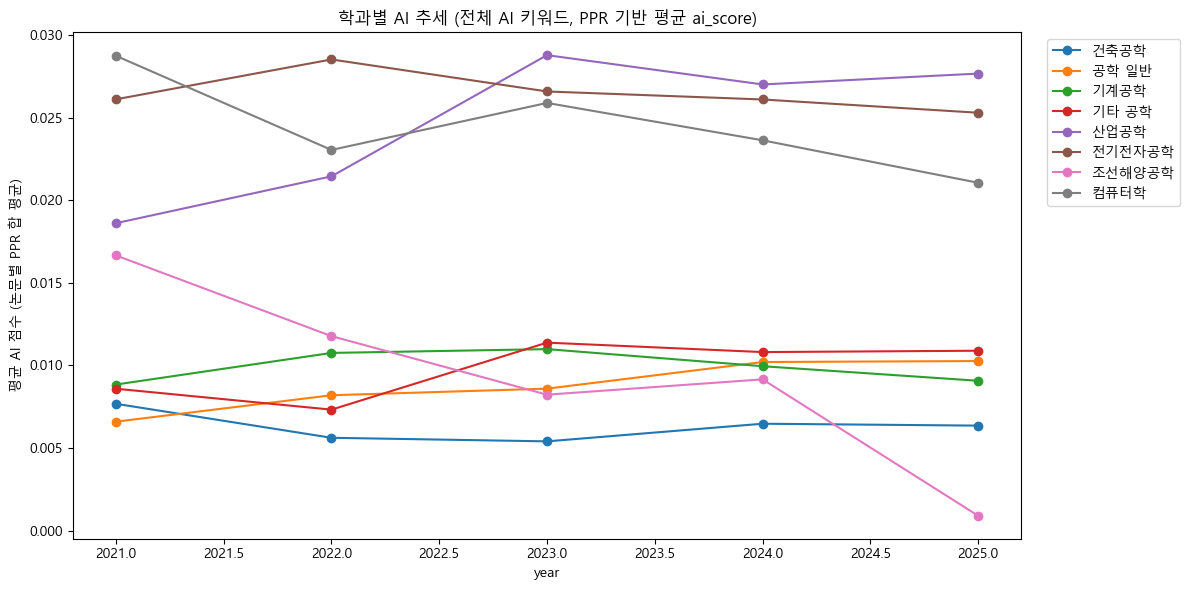

field2,건축공학,공학 일반,기계공학,기타 공학,산업공학,전기전자공학,조선해양공학,컴퓨터학
year,,,,,,,,
2021,0.007675,0.006592,0.008841,0.008587,0.018609,0.026109,0.016658,0.028743
2022,0.005616,0.008192,0.010755,0.007321,0.021446,0.028522,0.011771,0.023044
2023,0.005400,0.008592,0.010985,0.011378,0.028782,0.026584,0.008226,0.025890
2024,0.006468,0.010203,0.009950,0.010806,0.027009,0.026099,0.009154,0.023628
2025,0.006353,0.010263,0.009069,0.010887,0.027667,0.025297,0.000900,0.021057


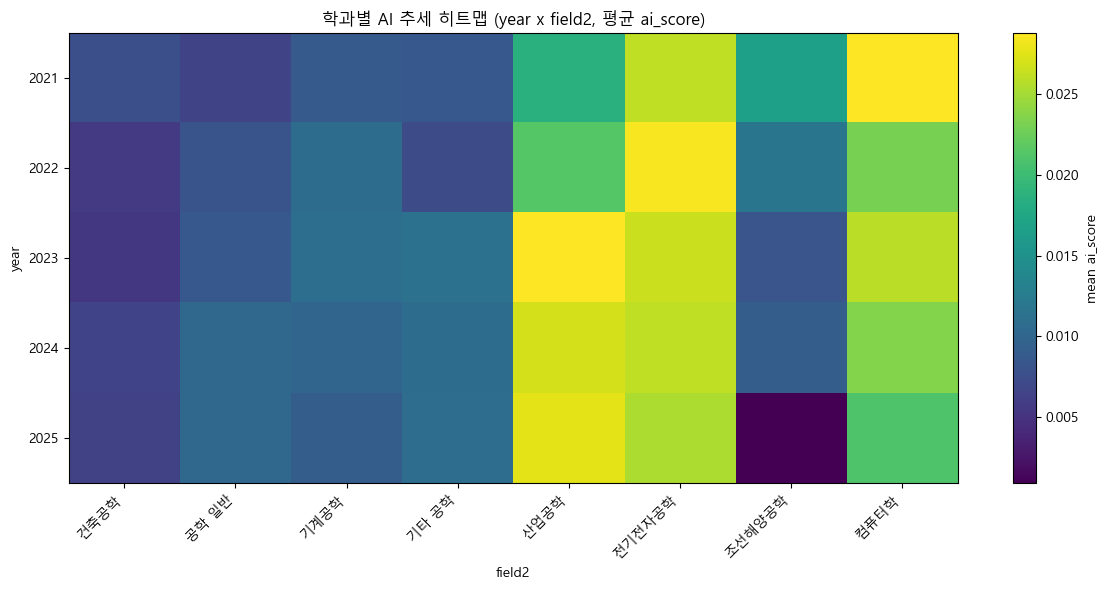

In [ ]:
# 논문별 ai_score 계산 (PPR 합)
def doc_ai_score(kw_list):
    if not isinstance(kw_list, list):
        return 0.0
    return float(sum(ppr_map.get(k, 0.0) for k in kw_list))

papers_net2["ai_score"] = papers_net2["kw_list_f"].apply(doc_ai_score)

print("ai_score describe:")
print(papers_net2["ai_score"].describe())

# 연도×학과(field2)별 평균 ai_score (추세)
df = papers_net2.copy()
df["field2"] = df["field2"].fillna("미상").astype(str).str.strip()

trend = (
    df.groupby(["year", "field2"])["ai_score"]
      .agg(total_papers="count", mean_ai_score="mean")
      .reset_index()
)

# 상위 학과 선정 기준 (전체 기간 ai_score 합 or 평균)
TOP_N = 8
top_fields = (
    trend.groupby("field2")["mean_ai_score"]
         .mean()
         .sort_values(ascending=False)
         .head(TOP_N)
         .index
)

plot_df = trend[trend["field2"].isin(top_fields)].copy()

pivot = plot_df.pivot_table(
    index="year",
    columns="field2",
    values="mean_ai_score",
    fill_value=0
).sort_index()

# 라인 차트
ax = pivot.plot(figsize=(12, 6), marker="o")
ax.set_title("학과별 AI 추세 (전체 AI 키워드, PPR 기반 평균 ai_score)")
ax.set_xlabel("year")
ax.set_ylabel("평균 AI 점수 (논문별 PPR 합 평균)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

display(pivot)

# 히트맵
mat = pivot.values
plt.figure(figsize=(12, 6))
im = plt.imshow(mat, aspect="auto")
plt.title("학과별 AI 추세 히트맵 (year x field2, 평균 ai_score)")
plt.xlabel("field2")
plt.ylabel("year")
plt.xticks(range(pivot.shape[1]), pivot.columns, rotation=45, ha="right")
plt.yticks(range(pivot.shape[0]), pivot.index)
plt.colorbar(im, label="mean ai_score")
plt.tight_layout()
plt.show()

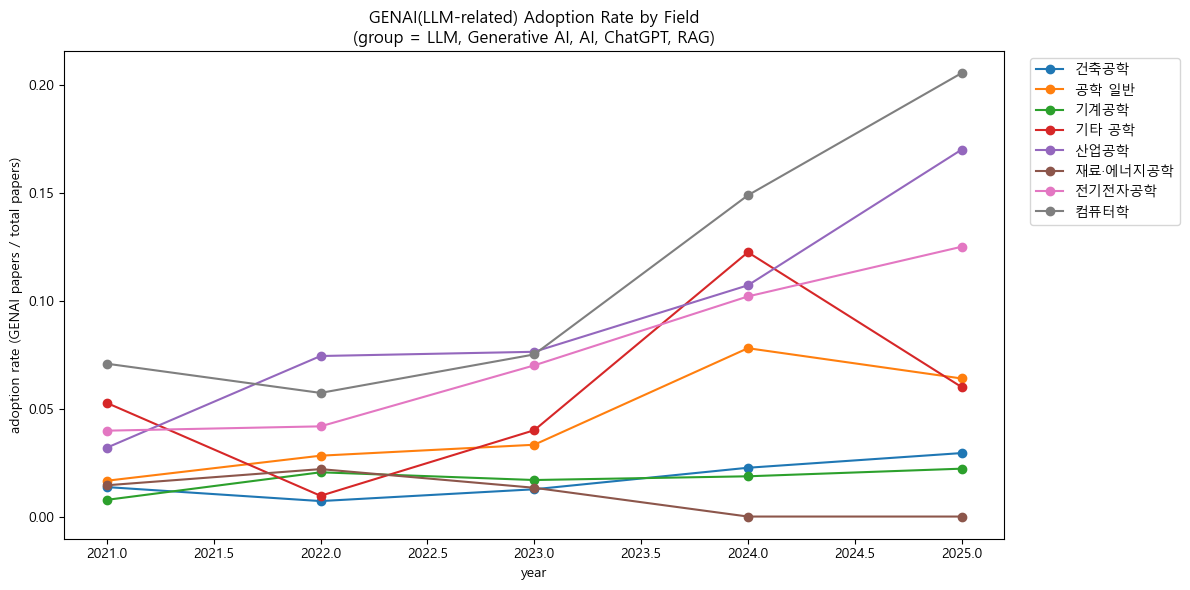

field2,건축공학,공학 일반,기계공학,기타 공학,산업공학,재료·에너지공학,전기전자공학,컴퓨터학
year,,,,,,,,
2021,0.013652,0.016598,0.007740,0.052632,0.031915,0.014493,0.039790,0.070812
2022,0.007168,0.028200,0.020505,0.009615,0.074380,0.021978,0.041789,0.057283
2023,0.012635,0.033264,0.016925,0.040000,0.076336,0.013333,0.070045,0.075110
2024,0.022609,0.078000,0.018651,0.122449,0.107143,0.000000,0.101985,0.148850
2025,0.029412,0.063966,0.022184,0.060000,0.170000,0.000000,0.125000,0.205455


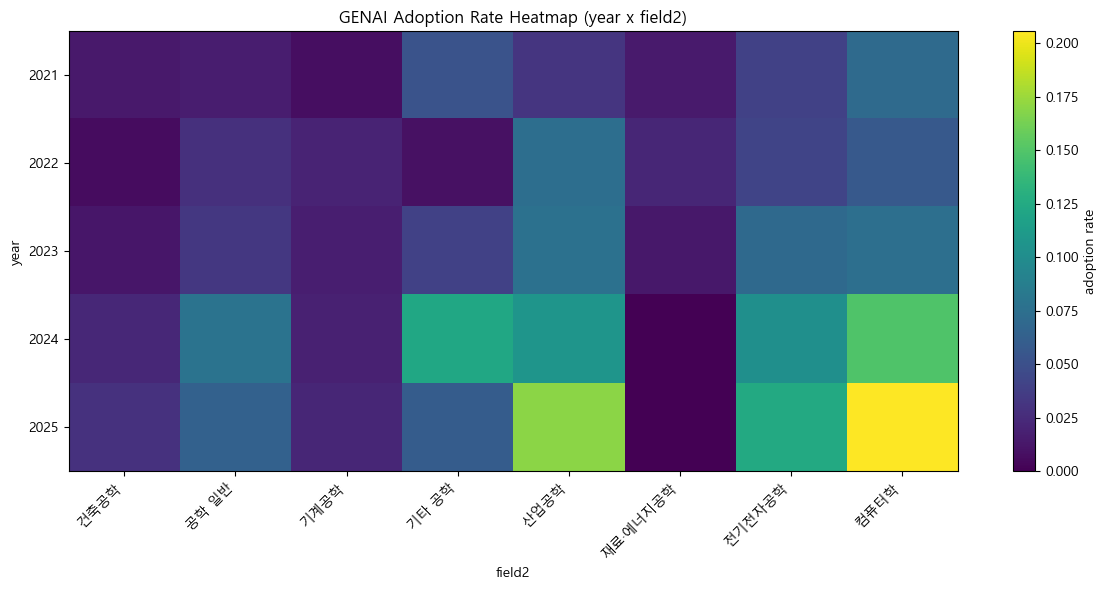

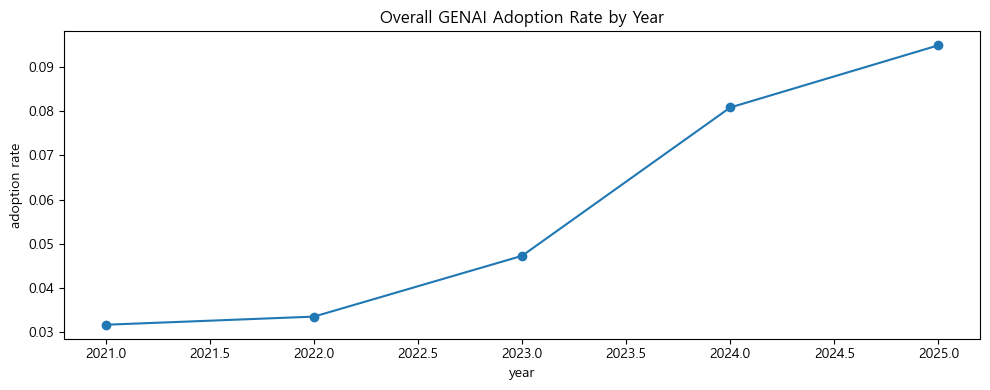

,year,overall_genai_adoption_rate
0,2021,0.031666
1,2022,0.033507
2,2023,0.047274
3,2024,0.080862
4,2025,0.094940


In [ ]:
# 묶을 키워드(소문자/정규화)
GENAI_GROUP = {
    "large language model",
    "generative ai",
    "artificial intelligence",
    "chatgpt",
    "retrieval augmented generation"
}

# 필수 컬럼 체크
need_cols = {"kw_list_f", "year", "field2"}
missing = need_cols - set(papers_net2.columns)
if missing:
    raise KeyError(f"papers_net2에 필요한 컬럼이 없습니다: {missing}")

# field2 정리
df = papers_net2.copy()
df["field2"] = df["field2"].fillna("미상").astype(str).str.strip()
df.loc[df["field2"] == "", "field2"] = "미상"

# 논문이 GENAI_GROUP을 포함하는지(1/0)
def doc_has_genai(kw_list):
    if not isinstance(kw_list, list):
        return 0
    return int(any(k in GENAI_GROUP for k in kw_list))

df["genai_flag"] = df["kw_list_f"].apply(doc_has_genai)

# 분모: 연도×학과 전체 논문 수
den = (
    df.groupby(["year", "field2"]).size()
      .rename("total_papers")
      .reset_index()
)

# 분자: 연도×학과 GENAI 포함 논문 수
num = (
    df[df["genai_flag"] == 1]
    .groupby(["year", "field2"]).size()
    .rename("genai_papers")
    .reset_index()
)

# 채택률(adoption rate) 계산
rate = den.merge(num, on=["year", "field2"], how="left")
rate["genai_papers"] = rate["genai_papers"].fillna(0).astype(int)
rate["adoption_rate"] = rate["genai_papers"] / rate["total_papers"]

# 시각화 대상 학과 선정 (전체기간 genai_papers 상위)
TOP_N = 8
top_fields = (
    rate.groupby("field2")["genai_papers"]
        .sum()
        .sort_values(ascending=False)
        .head(TOP_N)
        .index
)

plot_df = rate[rate["field2"].isin(top_fields)].copy()

pivot = plot_df.pivot_table(
    index="year",
    columns="field2",
    values="adoption_rate",
    fill_value=0
).sort_index()

# 라인 차트 (학과별 추세)
ax = pivot.plot(figsize=(12, 6), marker="o")
ax.set_title("GENAI(LLM-related) Adoption Rate by Field\n(group = LLM, Generative AI, AI, ChatGPT, RAG)")
ax.set_xlabel("year")
ax.set_ylabel("adoption rate (GENAI papers / total papers)")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

display(pivot)

# 히트맵
mat = pivot.values
plt.figure(figsize=(12, 6))
im = plt.imshow(mat, aspect="auto")
plt.title("GENAI Adoption Rate Heatmap (year x field2)")
plt.xlabel("field2")
plt.ylabel("year")
plt.xticks(range(pivot.shape[1]), pivot.columns, rotation=45, ha="right")
plt.yticks(range(pivot.shape[0]), pivot.index)
plt.colorbar(im, label="adoption rate")
plt.tight_layout()
plt.show()

# 연도별 전체 채택률
year_total = df.groupby("year").size()
year_genai = df[df["genai_flag"] == 1].groupby("year").size()
year_rate = (year_genai / year_total).fillna(0).reset_index()
year_rate.columns = ["year", "overall_genai_adoption_rate"]

plt.figure(figsize=(10, 4))
plt.plot(year_rate["year"], year_rate["overall_genai_adoption_rate"], marker="o")
plt.title("Overall GENAI Adoption Rate by Year")
plt.xlabel("year")
plt.ylabel("adoption rate")
plt.tight_layout()
plt.show()

display(year_rate)

# 토픽모델링

문서 수: 12927
예시 토큰: ['arsenic', 'artificial neural network', 'coefficient of determination', 'micellar enhanced ultrafiltration', 'root mean square error']
vocab: 1628
corpus: 12927


,K,coherence_cv,log_perplexity,accuracy_like,coh_norm,acc_norm,combined_score
0,3,0.629123,-6.407025,6.407025,0.979216,0.000000,0.783373
1,4,0.558467,-6.407321,6.407321,0.000000,0.002500,0.000500
2,5,0.597082,-6.431564,6.431564,0.535156,0.207070,0.469539
3,6,0.604395,-6.440971,6.440971,0.636510,0.286451,0.566498
4,7,0.622455,-6.469582,6.469582,0.886799,0.527884,0.815016
5,8,0.603405,-6.508610,6.508610,0.622780,0.857218,0.669667
6,9,0.602461,-6.513872,6.513872,0.609698,0.901622,0.668083
7,10,0.630623,-6.505183,6.505183,1.000000,0.828301,0.965660
8,11,0.627508,-6.525531,6.525531,0.956831,1.000000,0.965465
9,12,0.626806,-6.514030,6.514030,0.947105,0.902952,0.938275


best_k (coherence): 10
best_k (combined) : 10


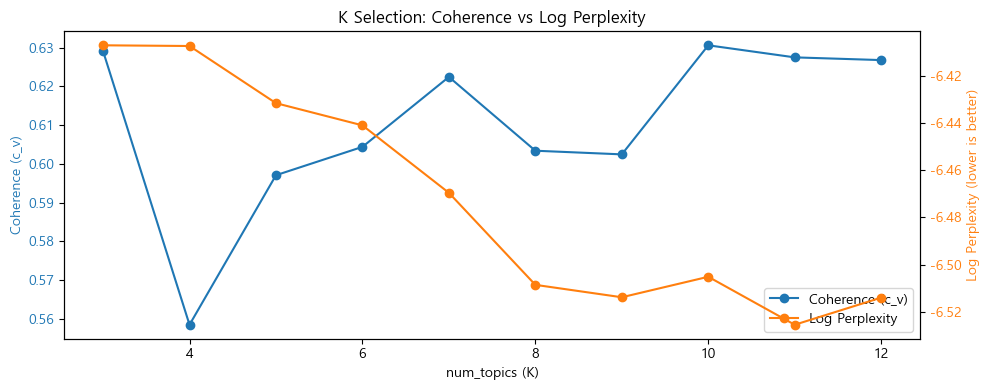

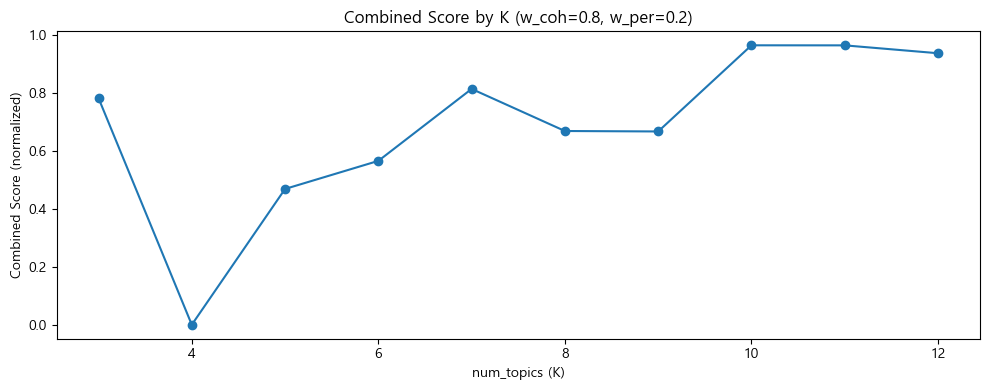

In [ ]:
DATA_PATH = "ai_only_df.csv"
KW_COL = "KYWD_NORM"

STOPWORDS = {
    "study","research","analysis","method","approach","result","based","using",
    "model","models","data","system","algorithm","algorithms","performance",
    "artificial intelligence","ai"
}

K_MIN, K_MAX = 3, 12
PASSES_EVAL = 20

# 종합점수 가중치
W_COH, W_PER = 0.8, 0.2

NO_BELOW, NO_ABOVE = 5, 0.6
RANDOM_STATE = 42

# 토큰화
df = pd.read_csv(DATA_PATH, encoding="utf-8-sig")
df = df[df[KW_COL].notna()].reset_index(drop=True)

def tokenize_keywords(s: str):
    s = str(s).lower().replace(";", ",")
    raw = [w.strip() for w in s.split(",") if w.strip()]
    raw = [w for w in raw if len(w) > 1]
    raw = [w for w in raw if w not in STOPWORDS]
    raw = [re.sub(r"\s+", " ", w).strip() for w in raw if w.strip()]
    return raw

texts = df[KW_COL].apply(tokenize_keywords).tolist()
print("문서 수:", len(texts))
print("예시 토큰:", texts[0][:15])

# Dictionary / Corpus
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=NO_BELOW, no_above=NO_ABOVE)
corpus = [dictionary.doc2bow(t) for t in texts]

print("vocab:", len(dictionary))
print("corpus:", len(corpus))

# K 후보 평가: coherence + log_perplexity
def minmax(s):
    return (s - s.min()) / (s.max() - s.min() + 1e-12)

def eval_k_models(k_values, corpus, dictionary, texts, passes=20, random_state=42):
    rows = []
    for k in k_values:
        lda = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=k,
            random_state=random_state,
            passes=passes,
            alpha="auto",
            eta="auto"
        )
        coherence = CoherenceModel(model=lda, texts=texts, dictionary=dictionary, coherence="c_v").get_coherence()
        log_perp = lda.log_perplexity(corpus)  # 낮을수록 좋음
        rows.append({"K": k, "coherence_cv": coherence, "log_perplexity": log_perp})
    return pd.DataFrame(rows)

k_values = list(range(K_MIN, K_MAX + 1))
metrics_df = eval_k_models(k_values, corpus, dictionary, texts, passes=PASSES_EVAL, random_state=RANDOM_STATE)

# 종합 점수
metrics_df["accuracy_like"] = -metrics_df["log_perplexity"]   # 높을수록 좋게 변환
metrics_df["coh_norm"] = minmax(metrics_df["coherence_cv"])
metrics_df["acc_norm"] = minmax(metrics_df["accuracy_like"])
metrics_df["combined_score"] = W_COH * metrics_df["coh_norm"] + W_PER * metrics_df["acc_norm"]

display(metrics_df)

best_k_coh = int(metrics_df.loc[metrics_df["coherence_cv"].idxmax(), "K"])
best_k_comb = int(metrics_df.loc[metrics_df["combined_score"].idxmax(), "K"])
print("best_k (coherence):", best_k_coh)
print("best_k (combined) :", best_k_comb)


# 시각화 (coherence vs perplexity)
fig, ax1 = plt.subplots(figsize=(10, 4))

l1 = ax1.plot(metrics_df["K"], metrics_df["coherence_cv"], marker="o", label="Coherence (c_v)", color="tab:blue")
ax1.set_xlabel("num_topics (K)")
ax1.set_ylabel("Coherence (c_v)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
l2 = ax2.plot(metrics_df["K"], metrics_df["log_perplexity"], marker="o", label="Log Perplexity", color="tab:orange")
ax2.set_ylabel("Log Perplexity (lower is better)", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

lines = l1 + l2
labels = [x.get_label() for x in lines]
ax1.legend(lines, labels, loc="best")

plt.title("K Selection: Coherence vs Log Perplexity")
plt.tight_layout()
plt.show()

# 종합점수 그래프
plt.figure(figsize=(10, 4))
plt.plot(metrics_df["K"], metrics_df["combined_score"], marker="o")
plt.xlabel("num_topics (K)")
plt.ylabel("Combined Score (normalized)")
plt.title(f"Combined Score by K (w_coh={W_COH}, w_per={W_PER})")
plt.tight_layout()
plt.show()

In [ ]:
# 생략 없이 출력
pd.set_option("display.max_colwidth", None)

FINAL_K = 10
PASSES_FINAL = 30
RANDOM_STATE = 42
TOPN_WORDS = 5

K_MIN, K_MAX = int(metrics_df["K"].min()), int(metrics_df["K"].max())
if not (K_MIN <= FINAL_K <= K_MAX):
    raise ValueError(f"FINAL_K={FINAL_K} 는 평가 범위({K_MIN}~{K_MAX}) 밖입니다.")

# 최종 LDA 학습
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=FINAL_K,
    random_state=RANDOM_STATE,
    passes=PASSES_FINAL,
    alpha="auto",
    eta="auto"
)

topic_words = {tid: [w for w, _ in lda_model.show_topic(tid, topn=TOPN_WORDS)] for tid in range(FINAL_K)}

doc_lens = np.array([sum(cnt for _, cnt in bow) for bow in corpus], dtype=float)
topic_mass = np.zeros(FINAL_K, dtype=float)

for bow, L in zip(corpus, doc_lens):
    if L == 0:
        continue
    for tid, prob in lda_model.get_document_topics(bow, minimum_probability=0):
        topic_mass[tid] += prob * L

topic_ratio = topic_mass / topic_mass.sum() * 100

result = pd.DataFrame({
    "토픽 번호": list(range(1, FINAL_K + 1)),
    "토픽명": [f"(임시) Topic {i+1}" for i in range(FINAL_K)],
    "주요 단어(내림차순, 5개)": [", ".join(topic_words[i]) for i in range(FINAL_K)],
    "전체 토큰 대비 비중(%)": np.round(topic_ratio, 1)
}).sort_values("전체 토큰 대비 비중(%)", ascending=False).reset_index(drop=True)

display(result)

,토픽 번호,토픽명,"주요 단어(내림차순, 5개)",전체 토큰 대비 비중(%)
0,7,(임시) Topic 7,"deep learning, object detection, generative ai, data augmentation, digital forensic",17.4
1,5,(임시) Topic 5,"convolutional neural network, internet of things, computer vision, drone, topic modeling",12.5
2,2,(임시) Topic 2,"machine learning, autonomous driving, neural network, semantic segmentation, attention mechanism",10.6
3,3,(임시) Topic 3,"large language model, reinforcement learning, long short-term memory, anomaly detection, generative adversarial network",10.3
4,9,(임시) Topic 9,"optimization, simulation, big data, artificial neural network, classification",9.0
5,6,(임시) Topic 6,"nursing, blockchain, transformer, chatgpt, smart factory",8.8
6,8,(임시) Topic 8,"virtual reality, metaverse, text mining, digital twin, user experience",8.3
7,4,(임시) Topic 4,"computational fluid dynamic, natural language processing, image classification, prompt engineering, data analysis",7.8
8,1,(임시) Topic 1,"unmanned aerial vehicle, federated learning, path planning, clustering, lithium-ion battery",7.7
9,10,(임시) Topic 10,"covid-19, deep neural network, explainable ai, random forest, prediction",7.4


In [ ]:
pd.set_option("display.max_colwidth", None)

FINAL_K = 7
PASSES_FINAL = 30
RANDOM_STATE = 42
TOPN_WORDS = 5

# 범위 체크
K_MIN, K_MAX = int(metrics_df["K"].min()), int(metrics_df["K"].max())
if not (K_MIN <= FINAL_K <= K_MAX):
    raise ValueError(f"FINAL_K={FINAL_K} 는 평가 범위({K_MIN}~{K_MAX}) 밖입니다.")

# 최종 LDA 학습
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=FINAL_K,
    random_state=RANDOM_STATE,
    passes=PASSES_FINAL,
    alpha="auto",
    eta="auto"
)

topic_words = {tid: [w for w, _ in lda_model.show_topic(tid, topn=TOPN_WORDS)] for tid in range(FINAL_K)}

doc_lens = np.array([sum(cnt for _, cnt in bow) for bow in corpus], dtype=float)
topic_mass = np.zeros(FINAL_K, dtype=float)

for bow, L in zip(corpus, doc_lens):
    if L == 0:
        continue
    for tid, prob in lda_model.get_document_topics(bow, minimum_probability=0):
        topic_mass[tid] += prob * L

topic_ratio = topic_mass / topic_mass.sum() * 100

result = pd.DataFrame({
    "토픽 번호": list(range(1, FINAL_K + 1)),
    "토픽명": [f"(임시) Topic {i+1}" for i in range(FINAL_K)],
    "주요 단어(내림차순, 5개)": [", ".join(topic_words[i]) for i in range(FINAL_K)],
    "전체 토큰 대비 비중(%)": np.round(topic_ratio, 1)
}).sort_values("전체 토큰 대비 비중(%)", ascending=False).reset_index(drop=True)

display(result)

,토픽 번호,토픽명,"주요 단어(내림차순, 5개)",전체 토큰 대비 비중(%)
0,1,(임시) Topic 1,"deep learning, convolutional neural network, long short-term memory, drone, image classification",20.1
1,2,(임시) Topic 2,"machine learning, object detection, autonomous driving, transformer, deep neural network",15.7
2,5,(임시) Topic 5,"internet of things, covid-19, computer vision, image processing, artificial neural network",13.9
3,3,(임시) Topic 3,"reinforcement learning, virtual reality, metaverse, anomaly detection, generative adversarial network",13.2
4,7,(임시) Topic 7,"large language model, optimization, data augmentation, digital forensic, security",13.2
5,4,(임시) Topic 4,"computational fluid dynamic, unmanned aerial vehicle, simulation, big data, text mining",13.0
6,6,(임시) Topic 6,"generative ai, nursing, digital twin, depression, blockchain",10.9


In [ ]:
pd.set_option("display.max_colwidth", None)

FINAL_K = 6
PASSES_FINAL = 30
RANDOM_STATE = 42
TOPN_WORDS = 5

# 범위 체크
K_MIN, K_MAX = int(metrics_df["K"].min()), int(metrics_df["K"].max())
if not (K_MIN <= FINAL_K <= K_MAX):
    raise ValueError(f"FINAL_K={FINAL_K} 는 평가 범위({K_MIN}~{K_MAX}) 밖입니다.")

# 최종 LDA 학습
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=FINAL_K,
    random_state=RANDOM_STATE,
    passes=PASSES_FINAL,
    alpha="auto",
    eta="auto"
)

topic_words = {tid: [w for w, _ in lda_model.show_topic(tid, topn=TOPN_WORDS)] for tid in range(FINAL_K)}

doc_lens = np.array([sum(cnt for _, cnt in bow) for bow in corpus], dtype=float)
topic_mass = np.zeros(FINAL_K, dtype=float)

for bow, L in zip(corpus, doc_lens):
    if L == 0:
        continue
    for tid, prob in lda_model.get_document_topics(bow, minimum_probability=0):
        topic_mass[tid] += prob * L

topic_ratio = topic_mass / topic_mass.sum() * 100

result = pd.DataFrame({
    "토픽 번호": list(range(1, FINAL_K + 1)),
    "토픽명": [f"(임시) Topic {i+1}" for i in range(FINAL_K)],
    "주요 단어(내림차순, 5개)": [", ".join(topic_words[i]) for i in range(FINAL_K)],
    "전체 토큰 대비 비중(%)": np.round(topic_ratio, 1)
}).sort_values("전체 토큰 대비 비중(%)", ascending=False).reset_index(drop=True)

display(result)

,토픽 번호,토픽명,"주요 단어(내림차순, 5개)",전체 토큰 대비 비중(%)
0,1,(임시) Topic 1,"deep learning, convolutional neural network, optimization, long short-term memory, data augmentation",24.3
1,2,(임시) Topic 2,"machine learning, object detection, large language model, computer vision, autonomous driving",19.6
2,5,(임시) Topic 5,"internet of things, covid-19, anomaly detection, drone, image processing",15.1
3,6,(임시) Topic 6,"generative ai, nursing, natural language processing, blockchain, depression",14.6
4,3,(임시) Topic 3,"reinforcement learning, virtual reality, metaverse, digital twin, digital forensic",13.2
5,4,(임시) Topic 4,"computational fluid dynamic, unmanned aerial vehicle, simulation, big data, text mining",13.1


In [ ]:
# 토픽명
TOPIC_NAMES = {
    0: "딥러닝 핵심 모델 연구",
    1: "비전 AI 및 자율주행 시스템",
    4: "IoT 기반 이상 탐지",
    5: "보건계열 AI 활용 연구",
    2: "메타버스 및 가상 융합 기술",
    3: "시뮬레이션·텍스트 마이닝 분석"
}

# 토픽별 상위 키워드
topic_words = {
    tid: [w for w, _ in lda_model.show_topic(tid, topn=TOPN_WORDS)]
    for tid in range(FINAL_K)
}

# 토픽 비중 계산 (문서 길이 가중)
doc_lens = np.array([sum(cnt for _, cnt in bow) for bow in corpus], dtype=float)
topic_mass = np.zeros(FINAL_K, dtype=float)

for bow, L in zip(corpus, doc_lens):
    if L == 0:
        continue
    for tid, prob in lda_model.get_document_topics(bow, minimum_probability=0):
        topic_mass[tid] += prob * L

topic_ratio = topic_mass / topic_mass.sum() * 100

# TOPIC_NAMES 반영 표 생성
result = pd.DataFrame({
    "토픽 번호": list(range(1, FINAL_K + 1)),
    "토픽명": [TOPIC_NAMES[i] for i in range(FINAL_K)],
    "주요 단어(내림차순, 5개)": [
        ", ".join(topic_words[i]) for i in range(FINAL_K)
    ],
    "전체 토큰 대비 비중(%)": np.round(topic_ratio, 1)
}).sort_values(
    "전체 토큰 대비 비중(%)", ascending=False
).reset_index(drop=True)

display(result)

,토픽 번호,토픽명,"주요 단어(내림차순, 5개)",전체 토큰 대비 비중(%)
0,1,딥러닝 핵심 모델 연구,"deep learning, convolutional neural network, optimization, long short-term memory, data augmentation",24.3
1,2,비전 AI 및 자율주행 시스템,"machine learning, object detection, large language model, computer vision, autonomous driving",19.6
2,5,IoT 기반 이상 탐지,"internet of things, covid-19, anomaly detection, drone, image processing",15.1
3,6,보건계열 AI 활용 연구,"generative ai, nursing, natural language processing, blockchain, depression",14.6
4,3,메타버스 및 가상 융합 기술,"reinforcement learning, virtual reality, metaverse, digital twin, digital forensic",13.2
5,4,시뮬레이션·텍스트 마이닝 분석,"computational fluid dynamic, unmanned aerial vehicle, simulation, big data, text mining",13.1


In [ ]:
# PBSH: YYYYMM → YYYY
df["YEAR"] = df["PBSH"].astype(str).str[:4].astype(int)

doc_topic = np.zeros((len(corpus), FINAL_K))

for i, bow in enumerate(corpus):
    for tid, prob in lda_model.get_document_topics(bow, minimum_probability=0):
        doc_topic[i, tid] = prob

doc_topic_df = pd.DataFrame(
    doc_topic,
    columns=[TOPIC_NAMES[i] for i in range(FINAL_K)]
)

doc_topic_df["YEAR"] = df["YEAR"].values

year_topic_trend = (
    doc_topic_df
    .groupby("YEAR")
    .mean()
    .sort_index()
)

display(year_topic_trend.round(3))

,딥러닝 핵심 모델 연구,비전 AI 및 자율주행 시스템,메타버스 및 가상 융합 기술,시뮬레이션·텍스트 마이닝 분석,IoT 기반 이상 탐지,보건계열 AI 활용 연구
YEAR,,,,,,
2021,0.249,0.194,0.123,0.139,0.157,0.138
2022,0.246,0.190,0.132,0.136,0.157,0.139
2023,0.242,0.193,0.136,0.140,0.150,0.138
2024,0.242,0.199,0.135,0.134,0.145,0.146
2025,0.238,0.199,0.133,0.137,0.143,0.150


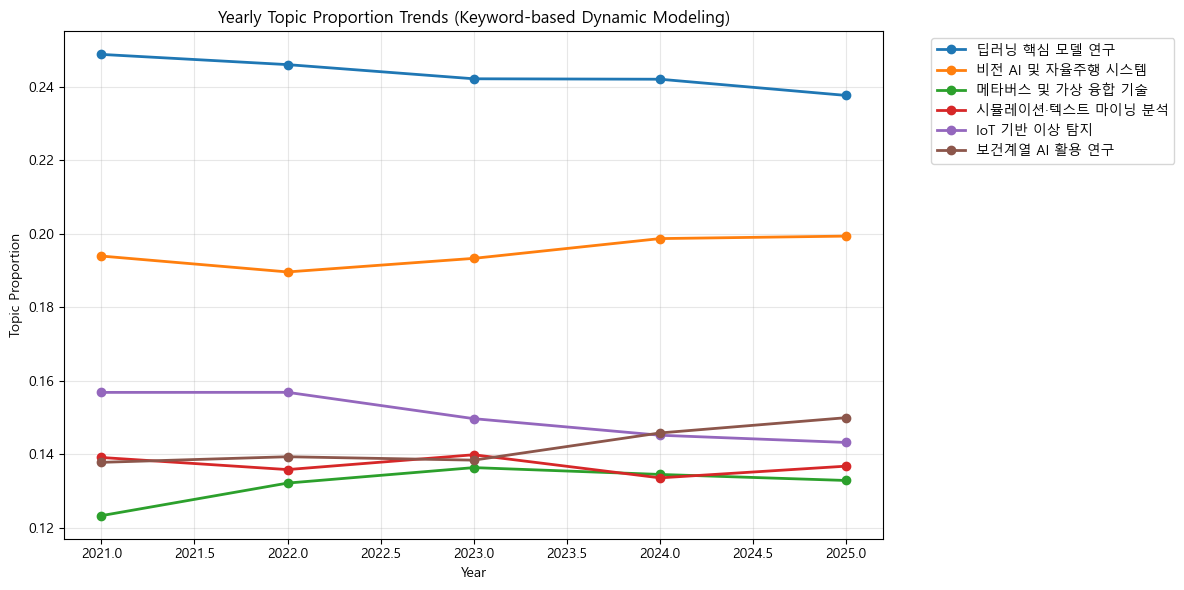

In [ ]:
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False
plt.figure(figsize=(12, 6))

for col in year_topic_trend.columns:
    plt.plot(
        year_topic_trend.index,
        year_topic_trend[col],
        marker="o",
        linewidth=2,
        label=col
    )

plt.xlabel("Year")
plt.ylabel("Topic Proportion")
plt.title("Yearly Topic Proportion Trends (Keyword-based Dynamic Modeling)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# 연도 만들기 (PBSH: YYYYMM -> YYYY)
df = df.copy()
df["YEAR"] = df["PBSH"].astype(str).str[:4]
df = df[df["YEAR"].str.fullmatch(r"\d{4}", na=False)].copy()
df["YEAR"] = df["YEAR"].astype(int)

if len(df) != len(corpus):
    raise ValueError(
        f"df({len(df)})와 corpus({len(corpus)}) 길이가 다릅니다. "
        "LDA에 사용한 df/corpus와 동일한 df여야 합니다."
    )

years = np.sort(df["YEAR"].unique())
K = FINAL_K
V = len(dictionary)

# 문서별 토픽분포 theta(d,k)
theta = np.zeros((len(corpus), K), dtype=float)
for i, bow in enumerate(corpus):
    for tid, prob in lda_model.get_document_topics(bow, minimum_probability=0):
        theta[i, tid] = prob

# 연도별 토픽-단어 확률 추정
#    - 문서 키워드 count를 토픽확률로 분배해서 누적
#    - 이후 토픽별로 정규화 => p(word | topic, year)
topic_word_year = {y: np.zeros((K, V), dtype=float) for y in years}

for i, bow in enumerate(corpus):
    y = df.loc[i, "YEAR"]
    for wid, cnt in bow:
        topic_word_year[y][:, wid] += theta[i, :] * cnt

topic_word_prob_year = {}
for y in years:
    mat = topic_word_year[y]
    denom = mat.sum(axis=1, keepdims=True)
    denom[denom == 0] = 1.0
    topic_word_prob_year[y] = mat / denom  # shape: (K, V)

# 논문 조건1: 전체기간 LDA에서 토픽 상위 10단어만 후보로 제한
topic_top10_wids = {}
for k in range(K):
    top = lda_model.show_topic(k, topn=10)
    topic_top10_wids[k] = [dictionary.token2id[w] for w, _ in top]

# 증가/감소 판단: 연도별 확률의 선형 추세(slope)
def slope_over_time(x_years, y_probs):
    if len(x_years) < 2:
        return 0.0
    return np.polyfit(x_years, y_probs, 1)[0]

N_SHOW = 2  # 논문 표3처럼 증가 2개/감소 2개

rows = []
for k in range(K):
    cand = topic_top10_wids[k]

    slope_list = []
    for wid in cand:
        probs = [topic_word_prob_year[y][k, wid] for y in years]
        s = slope_over_time(years, probs)
        slope_list.append((wid, s))

    # 증가/감소 정렬
    inc_sorted = sorted(slope_list, key=lambda x: x[1], reverse=True)
    dec_sorted = sorted(slope_list, key=lambda x: x[1])

    inc_words, dec_words = [], []

    for wid, s in inc_sorted:
        if s > 0:
            inc_words.append(dictionary[wid])
        if len(inc_words) >= N_SHOW:
            break

    for wid, s in dec_sorted:
        if s < 0:
            dec_words.append(dictionary[wid])
        if len(dec_words) >= N_SHOW:
            break

    rows.append({
        "순번": k + 1,
        "토픽명": TOPIC_NAMES.get(k, f"Topic {k+1}"),
        "증가": ", ".join(inc_words) if inc_words else "-",
        "감소": ", ".join(dec_words) if dec_words else "-"
    })

table3 = pd.DataFrame(rows)
display(table3)

,순번,토픽명,증가,감소
0,1,딥러닝 핵심 모델 연구,"data augmentation, long short-term memory","convolutional neural network, deep learning"
1,2,비전 AI 및 자율주행 시스템,"large language model, transformer","machine learning, deep neural network"
2,3,메타버스 및 가상 융합 기술,"reinforcement learning, federated learning","virtual reality, metaverse"
3,4,시뮬레이션·텍스트 마이닝 분석,"topic modeling, user experience","big data, simulation"
4,5,IoT 기반 이상 탐지,"anomaly detection, defect detection","covid-19, internet of things"
5,6,보건계열 AI 활용 연구,"generative ai, chatgpt","blockchain, smart factory"
